In [1]:
from PIL import Image, ImageFilter
import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.training import moving_averages
import tensorflow as tf
import glob
import random
import os
%matplotlib inline
from IPython.display import Image as Im

print ("Packs loaded.")

Packs loaded.


In [2]:
train_files = []
train_annotation = []

width = 256
height = 128
nrclass = 2

test_files = []
test_annotation = []
root_dir = "/home/mediwhale-3/blackbox_data/"
for folder in ["1/","2/","3/","4/","5/"] :
    frames = os.listdir(root_dir+"frame_mask/"+"frame"+folder)
    
    for f in frames :
        train_annotation.append(root_dir+"frame_mask/"+"frame"+folder+f)
        train_files.append(root_dir+"frames/"+"frame"+folder+f)
        
for folder in ["1/","3/"] :
    frames = os.listdir(root_dir+"frame_mask/"+"frame"+folder)
    
    for f in frames :
        test_annotation.append(root_dir+"frame_mask/"+"frame"+folder+f)
        test_files.append(root_dir+"frames/"+"frame"+folder+f)



train_files = [ x for x in train_files if ".ipynb_checkpoints" not in x ]
train_annotation = [ x for x in train_annotation if ".ipynb_checkpoints" not in x ]
test_files = [ x for x in test_files if ".ipynb_checkpoints" not in x ]
test_annotation = [ x for x in test_annotation if ".ipynb_checkpoints" not in x ]

train_files = np.array(train_files)
train_annotation = np.array(train_annotation)

test_files = np.array(test_files)
test_annotation = np.array(test_annotation)

def DenseToOneHot(arr) :
    anno = np.zeros((arr.shape[0],arr.shape[1],nrclass))
    
    black = 0
    white = 0
    
    for x in range(arr.shape[0]) :
        for y in range(arr.shape[1]) :
            if arr[x][y] < 128 :
                anno[x][y] = [1,0]
                black += 1
            else :
                anno[x][y] = [0,1]
                white += 1
                
    return anno

       
def train_batch(batch_size=20) :
               
               
               
    indices=random.sample(range(len(train_annotation)) , batch_size)
    batch_files=train_files[indices]
    batch_annotation=train_annotation[indices]
    
    origin = []
    annotation = []
       
    for t,a in zip(batch_files,batch_annotation) :
        
        o = Image.open(t).resize((width,height))
        a = Image.open(a).resize((width,height))
        
        augment = random.randrange(0,3)
        
        if augment % 3 == 0 :
            o = o.transpose(Image.FLIP_LEFT_RIGHT)
            a = a.transpose(Image.FLIP_LEFT_RIGHT)
        elif augment % 3 == 1 :
            o = o.filter(ImageFilter.BLUR)
        
        
        
        origin.append(np.array(o))
        annotation.append(DenseToOneHot(np.array(a)))
    
    return np.array(origin), np.array(annotation)

def test_batch(batch_size=20) :
    indices=random.sample(range(len(test_annotation)) , batch_size)
    batch_files=test_files[indices]
    batch_annotation=test_annotation[indices]
    
    origin = []
    annotation = []
          
    for t,a in zip(batch_files,batch_annotation) :
        origin.append(np.array(Image.open(t).resize((width,height))))
        annotation.append(DenseToOneHot(np.array(Image.open(a).resize((width,height)))))
    
    return np.array(origin), np.array(annotation)


def result_batch(batch_size) :
    indices=random.sample(range(len(test_annotation)) , batch_size)
    batch_files=test_files[indices]
    batch_annotation=test_annotation[indices]
    
    origin = []
    annotation = []
    origin_imgs = []
    annotation_imgs = []
    files = []
          
    for t,a in zip(batch_files,batch_annotation) :
        origin_imgs.append(Image.open(t))
        files.append(f)
        annotation_imgs.append(Image.open(a))
        
        origin.append(np.array(Image.open(t).resize((width,height))))
        annotation.append(DenseToOneHot(np.array(Image.open(a).resize((width,height)))))
    
    return np.array(origin), np.array(annotation),origin_imgs,annotation_imgs,files
        

In [3]:

x = tf.placeholder(tf.float32, [None, height, width, 3],name="x")
y = tf.placeholder(tf.float32, [None, height, width, nrclass],name="y")

keepprob = tf.placeholder(tf.float32,name="keepprob")

ksize = 3
fsize = 64
initstdev = 0.01
initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev)


weights = {
    'conv1_encoder': tf.get_variable("conv1_encoder", shape = [3, 3, 3, 64], initializer = initfun) ,
    'conv2_encoder': tf.get_variable("conv2_encoder", shape = [3, 3, 64, 64], initializer = initfun) ,
    'conv3_encoder': tf.get_variable("conv3_encoder", shape = [3, 3, 64, 128], initializer = initfun) ,
    'conv4_encoder': tf.get_variable("conv4_encoder", shape = [3, 3, 128, 128], initializer = initfun) ,
    'conv5_encoder': tf.get_variable("conv5_encoder", shape = [3, 3, 128, 256], initializer = initfun) ,
    'conv6_encoder': tf.get_variable("conv6_encoder", shape = [3, 3, 256, 256], initializer = initfun) ,
    'conv7_encoder': tf.get_variable("conv7_encoder", shape = [3, 3, 256, 256], initializer = initfun) ,
    
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, 256, nrclass]
                                       , initializer = initfun) # <= 1x1conv
}
biases = {
    'b1': tf.get_variable("be1", shape = [64], initializer = tf.constant_initializer(value=0.0)),
    'b2': tf.get_variable("be2", shape = [64], initializer = tf.constant_initializer(value=0.0)),
    'b3': tf.get_variable("be3", shape = [128], initializer = tf.constant_initializer(value=0.0)),
    'b4': tf.get_variable("be4", shape = [128], initializer = tf.constant_initializer(value=0.0)),
    'b5': tf.get_variable("bd4", shape = [256], initializer = tf.constant_initializer(value=0.0)),
    'b6': tf.get_variable("bd3", shape = [256], initializer = tf.constant_initializer(value=0.0)),
    'b7': tf.get_variable("bd2", shape = [256], initializer = tf.constant_initializer(value=0.0)),
    'bdp': tf.get_variable("bd1", shape = [256], initializer = tf.constant_initializer(value=0.0))
}

In [4]:
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.stack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output
    
    
# DeconvNet Model
def Model(_X, _W, _b, _keepprob):

    encoder1 = tf.nn.conv2d(_X, _W['conv1_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder1 = tf.nn.bias_add(encoder1, _b['b1'])
           
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder1 = tf.nn.batch_normalization(encoder1, mean, var, 0, 1, 0.0001)
    
    encoder1 = tf.nn.relu(encoder1)
    
    encoder2 = tf.nn.conv2d(encoder1, _W['conv2_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder2 = tf.nn.bias_add(encoder2, _b['b2'])
           
    mean, var = tf.nn.moments(encoder2, [0, 1, 2])
    encoder2 = tf.nn.batch_normalization(encoder2, mean, var, 0, 1, 0.0001)
    
    encoder2 = tf.nn.relu(encoder2)
    
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    
    #####################################################################################
    
    encoder3 = tf.nn.conv2d(encoder2, _W['conv3_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder3 = tf.nn.bias_add(encoder3, _b['b3'])
           
    mean, var = tf.nn.moments(encoder3, [0, 1, 2])
    encoder3 = tf.nn.batch_normalization(encoder3, mean, var, 0, 1, 0.0001)
    
    encoder3 = tf.nn.relu(encoder3)
    
    encoder4 = tf.nn.conv2d(encoder3, _W['conv4_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder4 = tf.nn.bias_add(encoder4, _b['b4'])
           
    mean, var = tf.nn.moments(encoder4, [0, 1, 2])
    encoder4 = tf.nn.batch_normalization(encoder4, mean, var, 0, 1, 0.0001)
    
    encoder4 = tf.nn.relu(encoder4)
    
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    
    #######################################################################################
    
    encoder5 = tf.nn.conv2d(encoder4, _W['conv5_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder5 = tf.nn.bias_add(encoder5, _b['b5'])
           
    mean, var = tf.nn.moments(encoder5, [0, 1, 2])
    encoder5 = tf.nn.batch_normalization(encoder5, mean, var, 0, 1, 0.0001)
    
    encoder5 = tf.nn.relu(encoder5)
    
    encoder6 = tf.nn.conv2d(encoder5, _W['conv6_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder6 = tf.nn.bias_add(encoder6, _b['b6'])
           
    mean, var = tf.nn.moments(encoder6, [0, 1, 2])
    encoder6 = tf.nn.batch_normalization(encoder6, mean, var, 0, 1, 0.0001)
    
    encoder6 = tf.nn.relu(encoder6)
    
    encoder7 = tf.nn.conv2d(encoder6, _W['conv7_encoder'], strides=[1, 1, 1, 1], padding='SAME')
    encoder7 = tf.nn.bias_add(encoder6, _b['b7'])
           
    mean, var = tf.nn.moments(encoder7, [0, 1, 2])
    encoder7 = tf.nn.batch_normalization(encoder7, mean, var, 0, 1, 0.0001)
    
    encoder7 = tf.nn.relu(encoder7)
    
    encoder7 = tf.nn.max_pool(encoder7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    encoder7 = tf.nn.dropout(encoder7, _keepprob)
    
    #######################################################################################
    
    
    encoder7 = tf.image.resize_images(encoder7, [height, width])
    
    output = tf.nn.softmax(tf.nn.conv2d(encoder7, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME'))
    
    return output

print ("Network ready")    

Network ready


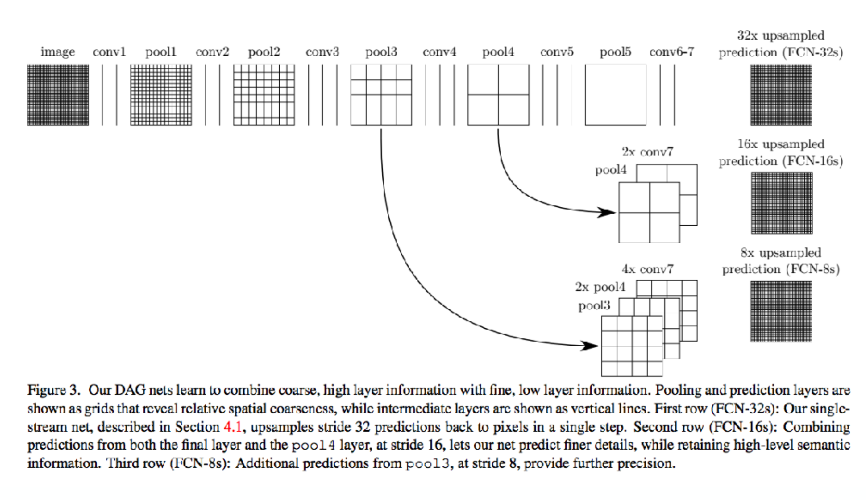

In [5]:
Im(filename="../pic/FCN.png")

In [6]:
pred = Model(x, weights, biases, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = lin_pred, labels=lin_y))
# Class label
predmax = tf.argmax(pred, 3,name="predmax")
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 20
n_epochs = 201

print ("Functions ready")

Functions ready


In [7]:
resumeTraining = False
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    #saver.restore(sess, "sess/segmentation/150.ckpt")

    
    for epoch_i in range(1,n_epochs):
        trainLoss = []; trainAcc = []

        for _ in range(batch_size):
            batchData, batchLabel = train_batch(batch_size=5)
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7}) # <== Optm is done here!
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        
        testData, testLabelOneHot = test_batch(batch_size=20)
        
        valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
               % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))
        # Save snapshot
        

#     testData, testLabelOneHot, origin_imgs, annotation_imgs,files = result_batch(batch_size=10)

#     for data,label,o,a,f in zip(testData,testLabelOneHot,origin_imgs,annotation_imgs,files) :
#         result = sess.run(predmax, feed_dict={x: testData,y:testLabelOneHot , keepprob: 1.})

#         for r,a,f in zip(result,annotation_imgs,files) :
#             prediction = Image.new("L",(width,height))
            
#             for y in range(r.shape[0]) :
#                 for x in range(r.shape[1]) :
#                     if r[y][x] == 1 :
#                         prediction.putpixel((x,y),(255))
#                     else :
#                         prediction.putpixel((x,y),(0))
#             plt.figure()
#             plt.imshow(o)
#             plt.figure()
#             plt.imshow(a)
#             plt.figure()
#             plt.imshow(prediction)


print ("Done")

[01/201] trainLoss: 0.4896 trainAcc: 0.80 valLoss: 0.4238 valAcc: 0.84
[02/201] trainLoss: 0.4327 trainAcc: 0.80 valLoss: 0.3740 valAcc: 0.87
[03/201] trainLoss: 0.4184 trainAcc: 0.82 valLoss: 0.3788 valAcc: 0.84
[04/201] trainLoss: 0.3852 trainAcc: 0.84 valLoss: 0.3770 valAcc: 0.83
[05/201] trainLoss: 0.3737 trainAcc: 0.84 valLoss: 0.3297 valAcc: 0.87
[06/201] trainLoss: 0.3546 trainAcc: 0.85 valLoss: 0.3348 valAcc: 0.89
[07/201] trainLoss: 0.3477 trainAcc: 0.85 valLoss: 0.3130 valAcc: 0.88
[08/201] trainLoss: 0.3355 trainAcc: 0.86 valLoss: 0.3142 valAcc: 0.87
[09/201] trainLoss: 0.3115 trainAcc: 0.87 valLoss: 0.2960 valAcc: 0.89
[10/201] trainLoss: 0.3173 trainAcc: 0.87 valLoss: 0.2961 valAcc: 0.89
[11/201] trainLoss: 0.3197 trainAcc: 0.86 valLoss: 0.3161 valAcc: 0.87
[12/201] trainLoss: 0.3002 trainAcc: 0.87 valLoss: 0.2564 valAcc: 0.90
[13/201] trainLoss: 0.3022 trainAcc: 0.87 valLoss: 0.2210 valAcc: 0.92
[14/201] trainLoss: 0.3055 trainAcc: 0.87 valLoss: 0.2800 valAcc: 0.89
[15/20

KeyboardInterrupt: 